In [ ]:
import sys,os

In [ ]:
# sys.path.append("/opt/notebooks/GPU-GWAS/")
# os.chdir("/opt/notebooks/GPU-GWAS/")

In [3]:
import argparse
import time
from collections import defaultdict

import cupy as cp
import cudf
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import gpugwas.io as gwasio
import gpugwas.algorithms as algos
import gpugwas.dataprep as dp
import gpugwas.runner as runner

from gpugwas.vizb import show_qq_plot, show_manhattan_plot

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

Loading BokehJS ...

In [4]:
vcf_path='./data/test.vcf'
annotation_path='./data/1kg_annotations.txt'

## Load data into dataframes

In [5]:
# Load data
vcf_df, feature_mapping = gwasio.load_vcf(vcf_path, info_keys=[], format_keys=["GT"])
#vcf_df = cudf.io.parquet.read_parquet("/data/1000-genomes/hail-dataset/1kg_full_jdaw_v2.pqt")
ann_df = gwasio.load_annotations(annotation_path)
print(vcf_df)
print("==")
print(ann_df)

[]
['GT']
       chrom        pos  ref  alt   sample        quality  feature_id  call_GT
0          1     904165    3    1  HG00096   52346.371094           0        0
1          1     904165    3    1  HG00099   52346.371094           0        0
2          1     904165    3    1  HG00105   52346.371094           0        0
3          1     904165    3    1  HG00118   52346.371094           0        0
4          1     904165    3    1  HG00129   52346.371094           0        0
...      ...        ...  ...  ...      ...            ...         ...      ...
252755     1  245840409    2    1  NA21114  185501.015625         889        0
252756     1  245840409    2    1  NA21116  185501.015625         889        1
252757     1  245840409    2    1  NA21118  185501.015625         889        1
252758     1  245840409    2    1  NA21133  185501.015625         889        1
252759     1  245840409    2    1  NA21143  185501.015625         889        1

[252760 rows x 8 columns]
==
       Sampl

## Generate phenotype dataframe by merging vcf and annotation DF

In [6]:
phenotypes_df, features = dp.create_phenotype_df(vcf_df, ann_df, ['CaffeineConsumption','isFemale','SuperPopulation'], "call_GT",
                                       vcf_sample_col="sample", ann_sample_col="Sample")

Merging annotations
         Sample Population SuperPopulation  isFemale  PurpleHair  \
0       HG02298        PEL             AMR      True        True   
1       HG02318        ACB             AFR      True        True   
2       HG02345        PEL             AMR      True       False   
3       HG02351        CDX             EAS     False       False   
4       HG02363        CDX             EAS     False       False   
...         ...        ...             ...       ...         ...   
252755  NA19446        LWK             AFR      True       False   
252756  NA19448        LWK             AFR     False       False   
252757  NA19455        LWK             AFR     False        True   
252758  NA19456        LWK             AFR      True       False   
252759  NA19466        LWK             AFR     False        True   

        CaffeineConsumption chrom        pos  ref  alt   sample  \
0                         5     1    8991141    1    3  HG02298   
1                         3  

## Run PCA on phenotype matrix

In [7]:
# Run PCA on phenotype dataframe
phenotypes_df = algos.PCA_concat(phenotypes_df, 2)
print(phenotypes_df)

      Sample  CaffeineConsumption  isFemale SuperPopulation  variant_0  \
0    HG00096                    4     False             EUR       14.0   
1    HG00099                    4      True             EUR        5.0   
2    HG00105                    4     False             EUR        0.0   
3    HG00118                    3      True             EUR       20.0   
4    HG00129                    6     False             EUR       -1.0   
..       ...                  ...       ...             ...        ...   
279  NA21114                    6     False             SAS        0.0   
280  NA21116                    4     False             SAS        0.0   
281  NA21118                    6     False             SAS        0.0   
282  NA21133                    5     False             SAS        0.0   
283  NA21143                    5      True             SAS        0.0   

     variant_1  variant_2  variant_3  variant_4  variant_5  ...  variant_882  \
0          0.0       -4.0      

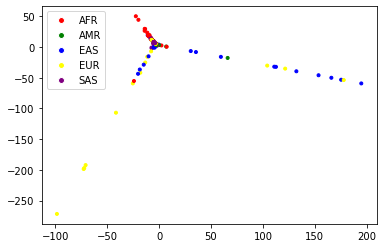

In [8]:
colors = {'AFR':'red', 'AMR':'green', 'EAS':'blue', 'EUR':'yellow', 'SAS':'purple'}
from matplotlib.lines import Line2D
plt.scatter(phenotypes_df.PC0.to_array(), phenotypes_df.PC1.to_array(), 
            c=phenotypes_df.SuperPopulation.to_pandas().map(colors).values, s=9)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=key, 
                          markerfacecolor=value) for key, value in colors.items()]
plt.legend(handles=legend_elements)

## Run GWAS with linear regression for each independent variant

In [9]:
# Fit linear regression model for each variant feature
print("Fitting linear regression model")

features.extend(['PC0', 'PC1'])
df = runner.run_gwas(phenotypes_df, 'CaffeineConsumption', features, algos.cuml_LinearReg)
print(df)

Fitting linear regression model
Visualizing p values
     feature  p_value  chrom
0          0    0.971      1
1          1    0.927      1
2          2    0.900      1
3          3    0.897      1
4          4    0.974      1
..       ...      ...    ...
887      887    0.991      1
888      888    0.997      1
889      889    0.994      1
890      890    0.999      1
891      891    0.998      1

[892 rows x 3 columns]


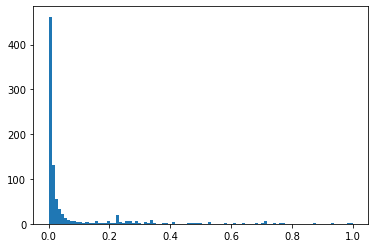

In [10]:
plt.hist(-np.log(df["p_value"].to_array()), bins = np.linspace(0,1,100));

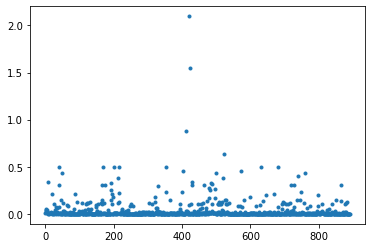

In [11]:
plt.plot(df["feature"].to_array(), -np.log10(df["p_value"].to_array()), ".");

In [17]:
show_manhattan_plot(df, 'chrom',  'pos', 'p_value')

,feature,p_value,chrom,e_value,p_s_value
0,0,0.971,1,0.000000,0.008
1,1,0.927,1,0.001122,0.028
2,2,0.900,1,0.002245,0.132
3,3,0.897,1,0.003367,0.231
4,4,0.974,1,0.004489,0.315
...,...,...,...,...,...
887,887,0.991,1,0.995511,1.000
888,888,0.997,1,0.996633,1.000
889,889,0.994,1,0.997755,1.000
890,890,0.999,1,0.998878,1.000


In [13]:
a = df["p_value"].to_array()
a.sort()
expect_p = np.linspace(0, 1, len(a))

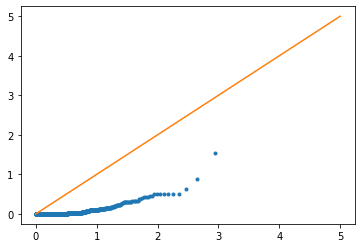

In [16]:
df["e_value"] = np.linspace(0, 1, len(a))
df["p_s_value"] = a
show_qq_plot(df, 'e_value', 'p_s_value')

plt.plot(-np.log10(expect_p), -np.log10(a), '.')
plt.plot([0,5],[0,5])


In [ ]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show

output_notebook()

plot = figure()
plot.circle(-np.log10(expect_p+1e-10), -np.log10(a))

handle = show(plot, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "qqplot"
push_notebook(handle=handle)

In [ ]:
!wget https://www.broadinstitute.org/files/shared/diabetes/scandinavs/DGI_chr3_pvals.txt

In [ ]:
pvals = []
with open('DGI_chr3_pvals.txt') as f:
    for r in f:
        r = r.strip()
        if r == 'PVAL':
            continue
        pvals.append(float(r))
pvals = np.array(pvals)

In [ ]:
pvals.sort()
expect_p = np.linspace(0, 1, len(pvals))

In [ ]:
plt.plot(-np.log10(expect_p), -np.log10(pvals), '.')
plt.plot([0,5],[0,5])

In [ ]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
f#rom bokeh.models import Range1d

output_notebook()


plot = figure(plot_width=300, plot_height=300, 
              y_range=(0,5),
              x_range=(0,5))
plot.circle(-np.log10(expect_p+1e-10), -np.log10(pvals))
plot.line([0,5],[0,5])

handle = show(plot, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "qqplot"
push_notebook(handle=handle)

In [ ]:
pvals